In [20]:
import pandas as pd
import numpy as np
import os
import joblib
import logging
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMRegressor, LGBMClassifier

from utils import MixtureOfExperts, model_pipeline

In [21]:
def preprocess_data(output_dir, datasets):
    preprocessed_data = {}

    for name, data in datasets.items():
        print(f"Processing {name}...")

        data.fillna(data.mean(numeric_only=True), inplace=True)  
    
        # numeric_cols = data.select_dtypes(include='number').columns
        # scaler = StandardScaler()  
        # data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

        try:
            data.drop(columns="Unnamed: 0", axis=1, inplace=True)
        except:
            pass
    
        preprocessed_data[name] = data

    for name, data in preprocessed_data.items():
        output_path = os.path.join(output_dir, f'{name}_preprocessed.csv')
        data.to_csv(output_path, index=False)

    print("Preprocessing complete. Files saved:")
    print(", ".join([os.path.join(output_dir, f"{name}_preprocessed.csv") for name in preprocessed_data]))

In [3]:
def create_features(df):
    df_processed = df.copy()
    df_processed.drop_duplicates(inplace=True)
    return df_processed

In [4]:
logging.basicConfig(level=logging.INFO)

def model_pipeline(df, target, task_type='regression', subset_frac=1.0, random_state=42):
    """
    Simplified pipeline focusing only on LightGBM and a MixtureOfExperts for regression or classification.
    """
    
    # Identify categorical and numerical columns
    try:
        categorical_cols = df.select_dtypes(include=['object']).columns
        categorical_cols = categorical_cols.drop(target)
    except:
        categorical_cols = []

    try:
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
        numerical_cols = numerical_cols.drop(target)
    except:
        numerical_cols = []

    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )


    if task_type == 'regression':
        models_list = [
            (
                LGBMRegressor(random_state=random_state),
                {
                    'learning_rate': [0.01, 0.1],
                    'n_estimators': [100, 200]
                }
            ),
            (
                MixtureOfExperts(experts=[
                    LGBMRegressor(random_state=random_state),
                    LinearRegression()
                ]),
                {
                    # 'experts__0__learning_rate': [0.01, 0.1], # Not directly supported by default GridSearch 
                }
            )
        ]
        scoring_metric = 'neg_mean_squared_error'
        
    elif task_type == 'classification':
        # Example classification version with LightGBM + a simple MoE (LightGBM + SVC)
        models_list = [
            (
                LGBMClassifier(random_state=random_state),
                {
                    'learning_rate': [0.01, 0.1],
                    'n_estimators': [100, 200]
                }
            ),
            (
                MixtureOfExperts(experts=[
                    LGBMClassifier(random_state=random_state),
                    SVC(probability=True)
                ]),
                {
                }
            )
        ]
        scoring_metric = 'accuracy'
    else:
        raise ValueError("task_type must be either 'regression' or 'classification'")

    df_sampled = df.sample(frac=subset_frac, random_state=random_state)

    X = df_sampled.drop(columns=target)
    y = df_sampled[target]

    if task_type == 'classification':
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state, stratify=y
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=random_state
        )

    pipelines = [
        Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ]) for model, _ in models_list
    ]

    param_grids = [
        {
            f'model__{param}': values 
            for param, values in params.items()
        }
        for _, params in models_list
    ]

    results = []

    for i, (pipeline, param_grid) in tqdm(enumerate(zip(pipelines, param_grids)), total=len(pipelines)):

        try:
            grid_search = GridSearchCV(
                pipeline, 
                param_grid, 
                cv=5, 
                scoring=scoring_metric, 
                n_jobs=-1
            )
            
            grid_search.fit(X_train, y_train)

            best_score = -grid_search.best_score_ if scoring_metric == 'neg_mean_squared_error' else grid_search.best_score_

            print(f"Best CV score for {pipeline.named_steps['model'].__class__.__name__}: {best_score:.4f}")
            print(f"Best parameters: {grid_search.best_params_}\n")

            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)

            result_dict = {
                'model': pipeline.named_steps['model'].__class__.__name__,
                'best_score': best_score,
                'best_params': grid_search.best_params_,
                'X_train': X_train,
                'y_train': y_train,
                'X_test': X_test,
                'y_test': y_test,
                'y_pred': y_pred,
                'best_model': best_model
            }

            if task_type == 'regression':
                mse = mean_squared_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                print(f"Test Set Metrics for {pipeline.named_steps['model'].__class__.__name__}:")
                print(f"MSE: {mse:.4f}, R2: {r2:.4f}\n")
                result_dict['mse_test'] = mse
                result_dict['r2_test'] = r2
            else:
                accuracy = accuracy_score(y_test, y_pred)
                print(f"Test Set Metrics for {pipeline.named_steps['model'].__class__.__name__}:")
                print(f"Accuracy: {accuracy:.4f}\n")
                print(classification_report(y_test, y_pred))
                result_dict['accuracy_test'] = accuracy

            print("-"*30)
            results.append(result_dict)

        except Exception as e:
            print(f"An error occurred with model {i+1}: {e}")

    if len(results) == 0:
        raise RuntimeError("No valid results were obtained from the models.")
    
    if scoring_metric == 'neg_mean_squared_error':
        best_model_result = min(results, key=lambda x: x['best_score'])
    else:
        best_model_result = max(results, key=lambda x: x['best_score'])

    print(f"Best model overall: {best_model_result['model']}, score: {best_model_result['best_score']:.4f}")
    print(f"Best parameters: {best_model_result['best_params']}\n")

    os.makedirs("models_project", exist_ok=True)
    best_model_name = f"models_project/best_model_{task_type}_{target}.joblib"
    joblib.dump(best_model_result['best_model'], best_model_name)
    print(f"Best model saved as {best_model_name}")

    return results

In [5]:
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_results(results):
    for i, res in enumerate(results):
        model_name = res['model']
        y_test = res['y_test']
        y_pred = res['y_pred']
        residuals = y_test - y_pred

        plt.figure(figsize=(12,5))
    
        plt.subplot(1,2,1)
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
        plt.title(f"{model_name} - Predictions vs. Actual")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
    
        plt.subplot(1,2,2)
        stats.probplot(residuals, plot=plt)
        plt.title(f"{model_name} - Residuals QQ-Plot")
    
        plt.tight_layout()
        plt.show()

## Full pipeline code from preprocessing steps, feature engineering, to training and testing.

In [5]:
logging.basicConfig(level=logging.INFO)

data_dir = "Simusafe_Dataset"
output_dir = "preprocessed_data"

os.makedirs(output_dir, exist_ok=True)

about_data = pd.read_excel(os.path.join(data_dir, 'About_the_dataset.xlsx'))
simulation_data = pd.read_excel(os.path.join(data_dir, 'Feature_Simulation.xlsx'))
track_data = pd.read_excel(os.path.join(data_dir, 'Feature_Track.xlsx'))

datasets = {
    "about_data": about_data,
    "simulation_data": simulation_data,
    "track_data": track_data,
}


preprocess_data(output_dir, datasets)


df_merged = pd.merge(
    simulation_data, 
    track_data, 
    on="subject",   
    how="inner"            
)
for col in df_merged.columns:
    if col.endswith('_x'):
        base_col = col[:-2]  
        if f"{base_col}_y" in df_merged.columns:
            df_merged[base_col] = df_merged[[col, f"{base_col}_y"]].mean(axis=1)
            df_merged.drop(columns=[col, f"{base_col}_y"], inplace=True)

df_merged = create_features(df_merged)

df_merged.fillna(df_merged.mean(numeric_only=True), inplace=True)

df_merged.head()

Processing about_data...
Processing simulation_data...
Processing track_data...
Preprocessing complete. Files saved:
preprocessed_data\about_data_preprocessed.csv, preprocessed_data\simulation_data_preprocessed.csv, preprocessed_data\track_data_preprocessed.csv


,subject,lap,start_time,straight,roundabout_entry,roundabout_exit,zebra_crossing,left_turn,u_turn,bypass_dummy,...,LowerAlphaFrontal,LowerAlphaParietal,UpperAlphaFrontal,UpperAlphaParietal,BetaFrontal,BetaParietal,LowerBetaFrontal,LowerBetaParietal,UpperBetaFrontal,UpperBetaParietal
0,0AC2A4,1.0,10.0,1.0,0.5,0.0,0.5,0.5,0.0,0.0,...,0.128210,0.082745,0.128880,0.081355,0.052725,0.037850,0.079245,0.057820,0.036640,0.025520
1,0AC2A4,1.0,20.0,1.0,0.0,0.5,0.5,0.5,0.0,0.0,...,0.130295,0.079275,0.123950,0.076345,0.045530,0.031805,0.066905,0.050240,0.032845,0.020730
2,0AC2A4,1.0,23.0,1.0,0.0,0.0,1.0,0.5,0.0,0.0,...,0.160455,0.096085,0.112140,0.083800,0.046925,0.031095,0.068400,0.047970,0.034510,0.020720
3,0AC2A4,1.0,28.0,1.0,0.5,0.0,0.5,0.0,0.0,0.0,...,0.166230,0.103050,0.120695,0.093840,0.049590,0.032045,0.071620,0.050275,0.036165,0.020685
4,0AC2A4,1.0,35.5,1.0,0.5,0.0,0.5,0.0,0.0,0.0,...,0.168065,0.110955,0.128675,0.106425,0.046095,0.031175,0.066835,0.048165,0.033690,0.020775


In [12]:
df_merged.corr()

C:\Users\vince\AppData\Local\Temp\ipykernel_15752\2993353554.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_merged.corr()


,lap,start_time,straight,roundabout_entry,roundabout_exit,zebra_crossing,left_turn,u_turn,bypass_dummy,car,...,LowerAlphaFrontal,LowerAlphaParietal,UpperAlphaFrontal,UpperAlphaParietal,BetaFrontal,BetaParietal,LowerBetaFrontal,LowerBetaParietal,UpperBetaFrontal,UpperBetaParietal
lap,1.000000e+00,-0.112020,0.148320,-0.005449,-4.037939e-17,0.008751,-0.010572,-0.005227,0.004095,0.093640,...,-0.048319,-0.056919,-0.030462,-0.006232,-0.021745,-0.003122,-0.017412,0.005135,-0.023969,-0.011027
start_time,-1.120198e-01,1.000000,-0.064902,-0.131403,-5.378078e-02,-0.176628,0.184985,-0.052799,-0.077485,-0.059981,...,0.082037,0.105055,0.095163,0.101181,0.143666,0.113400,0.141232,0.111443,0.142415,0.110694
straight,1.483197e-01,-0.064902,1.000000,-0.005843,-1.132061e-01,-0.187701,0.094480,0.198368,0.055607,-0.024366,...,-0.095975,-0.134180,-0.098965,-0.125285,-0.097346,-0.125349,-0.106755,-0.132982,-0.087249,-0.110642
roundabout_entry,-5.448730e-03,-0.131403,-0.005843,1.000000,-2.367336e-01,0.307779,-0.156203,-0.151072,-0.057930,0.107874,...,-0.022022,-0.025955,-0.029439,-0.036011,-0.031369,-0.034396,-0.028995,-0.034809,-0.032165,-0.031242
roundabout_exit,-4.037939e-17,-0.053781,-0.113206,-0.236734,1.000000e+00,0.366270,-0.130895,-0.139356,-0.070899,0.006928,...,0.016132,0.003974,0.000468,-0.015230,0.005913,0.007855,0.003381,0.009431,0.007017,0.004578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BetaParietal,-3.122231e-03,0.113400,-0.125349,-0.034396,7.854673e-03,0.026332,-0.030971,0.008805,-0.032993,-0.004203,...,0.566445,0.605427,0.720055,0.771768,0.910064,1.000000,0.904022,0.974133,0.885783,0.969745
LowerBetaFrontal,-1.741182e-02,0.141232,-0.106755,-0.028995,3.381158e-03,0.006996,-0.013349,0.023500,-0.030509,0.009788,...,0.668366,0.620352,0.810703,0.745576,0.978433,0.904022,1.000000,0.896330,0.931921,0.861148
LowerBetaParietal,5.134503e-03,0.111443,-0.132982,-0.034809,9.430747e-03,0.027479,-0.032572,0.012255,-0.035554,-0.002583,...,0.619646,0.672234,0.753077,0.831068,0.869829,0.974133,0.896330,1.000000,0.820418,0.889906
UpperBetaFrontal,-2.396911e-02,0.142415,-0.087249,-0.032165,7.016808e-03,0.005081,-0.013397,0.012243,-0.023314,-0.000809,...,0.508025,0.465226,0.679599,0.605215,0.986503,0.885783,0.931921,0.820418,1.000000,0.905667


C:\Users\vince\AppData\Local\Temp\ipykernel_15752\746902440.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_merged.corr()


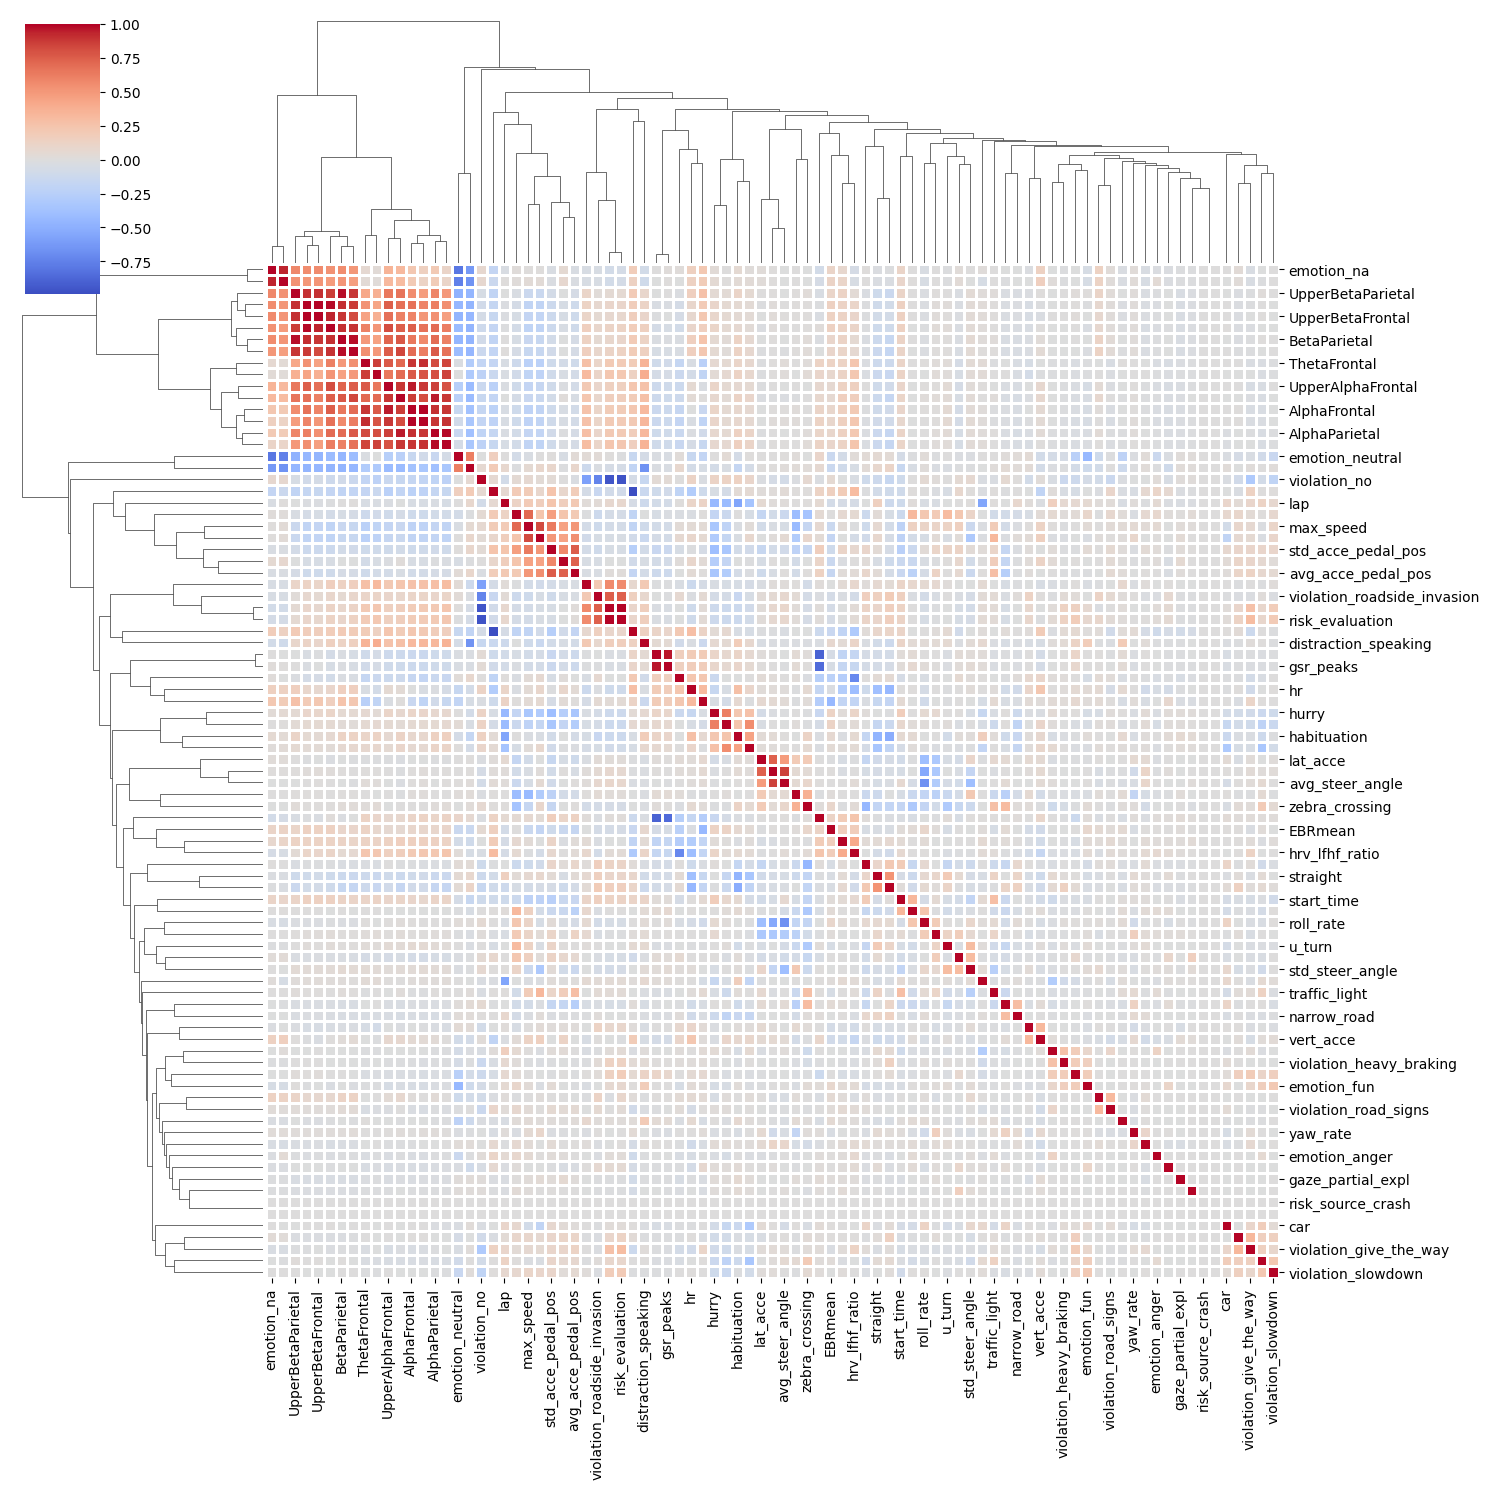

In [15]:
corr_matrix = df_merged.corr()
cleaned_corr_matrix = corr_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)
sns.clustermap(cleaned_corr_matrix, cmap='coolwarm', center=0, linewidths=0.75, figsize=(15, 15))
plt.show()

In [ ]:
target_column = 'risk_evaluation'
task_type = 'regression'  

results = model_pipeline(
    df=df_merged, 
    target=target_column, 
    task_type=task_type, 
    subset_frac=0.1, 
    random_state=42
)

for res in results:
    print(res['model'], res['best_score'], res['best_params'])

plot_results(results)

In [16]:
model_names = []
best_scores = []
best_params_list = []
mse_scores = []
r2_scores = []
y_pred_list = []

for result in results:
    y_test = result['y_test']
    model_names.append(result['model'])
    best_scores.append(result['best_score'])
    best_params_list.append(result['best_params'])
    y_pred = result['y_pred']
    y_pred_list.append(y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)

num_models = len(results)
fig, axes = plt.subplots(num_models, 2, figsize=(12, 4*num_models), squeeze=False)

for i in range(num_models):
    y_pred = y_pred_list[i]
    residuals = y_test - y_pred
    
    axes[i, 0].scatter(y_test, y_pred, color='blue', alpha=0.5)
    axes[i, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes[i, 0].set_xlabel('Actual Values')
    axes[i, 0].set_ylabel('Predicted Values')
    axes[i, 0].set_title(f'Predictions vs. Actual for {model_names[i]}')
    
    stats.probplot(residuals, plot=axes[i, 1])
    axes[i, 1].set_title(f'QQ-Plot of Residuals for {model_names[i]}')

plt.tight_layout()
plt.show()

summary_df = pd.DataFrame({
    'Model': model_names,
    'Best CV Score (Neg MSE)': best_scores,
    'MSE on Test Set': mse_scores,
    'R2 on Test Set': r2_scores,
    'Best Parameters': best_params_list
})

summary_df.to_csv("models_project/summary_regression_Overall.csv", index=False)
summary_df

NameError: name 'results' is not defined

In [ ]:
plt.figure(figsize=(10,6))
plt.bar(model_names, mse_scores, color='skyblue')
plt.title('Comparison of Models based on MSE')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.bar(model_names, r2_scores, color='lightgreen')
plt.title('Comparison of Models based on R² Score')
plt.xlabel('Models')
plt.ylabel('R² Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()